In [1]:
# in class using different functions 

import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr 
import datetime as dt 

import scipy 
from scipy import signal


C:\Users\vboat\conda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# function to download wind data and fill missing values 

def download_winds(url,plotting=0): 
    import numpy as np 
    import matplotlib.pyplot as plt
    import xarray as xr 
    import datetime as dt 
    import netCDF4

    
    s0 = dt.datetime(1950,1,1); 

    nc = netCDF4.Dataset(url)
    # making a date array based on time units from netcdf file
    time = nc['TIME'][:]; dates = [s0+dt.timedelta(days=float(tt)) for tt in time]
    ht = nc['HEIGHT'][:]
    lon = nc['LONGITUDE'][:]; lat = nc['LATITUDE'][:]

    wind = nc['WSPD'][:]; wind[wind<0] = np.nan # make nan when not physical 
    wind = np.squeeze(wind.data) # make into a 1D array (before it was a (47605,1) shaped array)
    # make into a xarray so we can use interpolate_na function 
    dw = xr.DataArray(data=wind.data,dims="time", coords={"time": time})
    dw = dw.interpolate_na(dim='time',method="linear")
    wind = dw.values
    
    u = nc['UWND'][:]; u[u<=-998] = np.nan # make nan when fillValue
    u = np.squeeze(u.data) # make into a 1D array (before it was a (47605,1) shaped array)
    du = xr.DataArray(data=u.data,dims="time", coords={"time": time})
    du = du.interpolate_na(dim='time',method="linear") 
    u = du.values
    
    v = nc['VWND'][:]; v[v<=-998] = np.nan # make nan when fillValue
    v = np.squeeze(v.data) # make into a 1D array (before it was a (47605,1) shaped array)
    dv = xr.DataArray(data=v.data,dims="time", coords={"time": time})
    dv = dv.interpolate_na(dim='time',method="linear") 
    v = dv.values
    
    # plot if desirable
    if plotting == 1: 
        plots = [wind,u,v]; labels = ['wind speed [m/s]','u [m/s]','v [m/s]']; titles = ['Total Wind Speed', 'Zonal Wind', 'Meridionial Wind']
        fig,axes = plt.subplots(3,1,figsize=(14,20))
        fig.suptitle('Raw Wind Speed Timeseries',y=0.95,fontweight='bold')
        for nn,ax in enumerate(axes): 
            ax.grid()
            ax.plot(dates,plots[nn])
            ax.set(ylabel=labels[nn]); # ax.set(title=titles[nn])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.tick_params(axis='x', labelrotation = -45)
        plt.show()
    
    return time, wind, u, v
    
    

In [3]:
# function for windowing  

def windowing(time,data,tseg=60,deltat=10): 
    # make sure time segments (tseg) must be in units of days 
    # this function will return segmented arrays (of size [#segments,#N samples of data in each segment]) from a dataset with an associated time vector 
    # time: full time dataset (in datenumbers/integers )
    # data: full dataset of interest 
    # tsegs: the number of days desired in your segmenting [ in days ]
    # deltat: the sample spacing between your datapoints [in minutes]
    # this assumes the dt is 10 min, but that could be easily changed - as long as it is in minutes!
    
    # returns: 
    # time_segs: segments with their original time stamps associated 
    # data_segs: segmented data as an array of [#segments,#N samples of data in each segment]

    import numpy as np 

    # number of tseg intervals encompassed in full dataset
    intervals = int(np.floor((time[-1]-time[0])/tseg))
    # with 50% overlaps, it will be doubled but 1 less (because start 50% and end 50%)
    cycles = (intervals*2)-1

    num_samples = int(tseg/deltat *60*24) # number of samples if taken every 10 min in 60 days 


    # can make arrays the correct size because we know how many 10 min samples will be in 60 days 
    # each array = (segment num, data within segment) 
    data_segs = np.zeros((cycles,num_samples))
    time_segs = np.zeros((cycles,num_samples))

    ind = 0
    jump = int(num_samples/2); 
    for nn in np.arange(0,cycles): 
        # looping through each segment in which we will save data 
        data_segs[nn,:] = data[ind:ind+num_samples]
        time_segs[nn,:] = time[ind:ind+num_samples]
        
        # now add to the ind (start index) and jump (number of samples in the segment = 8640)
        ind = ind + jump

    return time_segs,data_segs
    

In [4]:
# function for fft and spectra analysis 

def fft_analysis(data,time,demean=1,detrend=1,hanning=1,all_pars=0):
    # specifications for inputs: 
    # data_array should be size = (segments,data_in_segment); each data_in_segment column should be the same length
    # time array = should be the same size as data_array, could adapted for just a 1D vector. 
    # aka: you must window properly before using this function 
    # then, selecting whether to demean, detrend, hanning window, etc. 

    # returns: 
    # freqs: frequency array associated with spectrum/FFT
    # avg_fft: average fourier transform to plot (real & complex)
    # tot_amp: averaged spectrum 
    # err_low, err_high = high and low errors of dataset 

    import numpy as np 
    import matplotlib.pyplot as plt
    import xarray as xr 
    import datetime as dt 
    import scipy 
    from scipy import fft 
    from scipy import stats 
    
    
    # all segment lengths should be the same 
    N = len(data[0,:])  # == num_samples in each _window_
    deltat = np.diff(time)
    step = np.nanmean(deltat) # step size (in days)
    Nyq = 1/(2*step) # Nyquist frequency
    period = step*N # this is the entire period (in days)
    df = 1/period # fundamental frequency
    segs = len(data[:,0]) # total number of segment 
    M = segs
    
    # start workflow: analyze each segment individually 

    # fft & spectra of interest to be averaged 
    fft_oi = np.zeros((segs,N)) # real+complex FFT 
    amp_oi = np.zeros((segs,int(N/2))) # real spectra 
    
    # loop through segments
    for nn in np.arange(0,segs):
        segment = data[nn,:]
        segtime = time[nn,:]
    
        # demean & detrend 
    
        # calculate mean and linear trend 
        AA = np.array([np.ones(N), segtime]).T
        x = np.dot(np.linalg.inv(np.dot(AA.T, AA)), np.dot(AA.T, segment))
        mean = x[0]; trend = x[1]

        if demean==1: 
            segment = segment-mean # demean by calculated mean 
        
        if detrend==1: 
            segment = segment-trend*segtime # detrend from calculated trend
        
        if hanning==1: 
            hanwin = np.cos(np.pi*segtime / period)**2 # calculate hanning window
            segment = segment*hanwin*np.sqrt(8/3) # normalize hanning window by sqrt(8/3)
            
        # compute each segment spectrum 
        # fourier transform
        fft = scipy.fft.fft(segment); 
        freq = scipy.fft.fftfreq(N,step); freq = scipy.fft.fftshift(freq); real_freq = freq[freq>=0]
        fftplot = scipy.fft.fftshift(fft)
        norm_fft = 1.0/N * np.abs(fftplot) # normalizing shifted FFT 
    
        r_idx = np.nonzero(freq>=0)
        amp = (norm_fft[r_idx])**2 # only selecting >0 to ignore complex (symmetric about x=0) - then square for amp

        # do the steps for the spectrum: 
        # normalization already done above
        amp = amp*2 # account for discarded redundant complex FFT coefficients 
        amp = amp/df # spectrum is normalized by fundamental freq
        
        fft_oi[nn,:] = norm_fft
        amp_oi[nn,:] = amp
    
        # inner loop parsevals (if desired)
        if all_pars == 1: 
            print(f"data variance & fft variance: {np.nanvar(segment):.04f} and {(np.sum(amp)*df):.04f}")

    avg_fft = np.nanmean(fft_oi,axis=0)
    tot_amp = np.nanmean(amp_oi,axis=0)
    
    # parseval's check : 
    print(f'Check Parsevals - data variance equals integral of spectrum?')
    print(f'Data variance / spectrum integration: {(np.nanvar(data) / np.sum(tot_amp)*df ): 0.4f} ')
    
    nu = 2*M # degrees of freedom 
    top = 1-0.05/2; bot = 0.05/2 
    err_low = nu/(scipy.stats.chi2.ppf(top, nu)); err_high = nu/(scipy.stats.chi2.ppf(bot, nu))
    
    return real_freq, avg_fft, tot_amp, err_low, err_high

In [5]:
# grant's function for spectra 

def spectrum(data, interval, detrend=True, Hanning=True):
    '''
    This function is used to make a spectrum given a time-series dataset and the time interval between samples
    in the dataset.

    Arguments:
        data (array) : A 1-d data array of which to have the spectrum computed
        interval (float) : Time interval between samples in data
        detrend (boolean) : Whether the data should be detrended before the spectrum is found
        Hanning (boolean) : Whether a Hanning window should be applied to the data before the spectrum is found

    Returns:
        spectrum (array) : A 1-d array containing the spectral values of the input data, in units (data units)
                            squared per frequency (cycles per time interval unit)
        f_range_pos (array) : A 1-d array containing the frequency values corresponding to each spectral value,
                            in units of cycles per time interval unit
    '''
    import scipy.signal as signal
    N = len(data)
    f_range = np.fft.fftfreq(N, d=interval) #creating an array of frequencies
    f_range_pos = f_range[(f_range > 0)] #creating an array of positive frequencies
    delta_f = 1/(N*interval) #finding the fundamental frequency

    
    x = np.linspace(-0.5, 0.5, N) # Hanning domain
    hanning = np.sqrt(8/3)*((np.cos(x*np.pi))**2) # Hanning values

    # various different ffts to be taken, depending on the detrend and Hanning conditions
    if detrend and Hanning:
        fft=np.fft.fft(hanning*signal.detrend(data)) #applying Hanning window and detrend
    elif detrend and Hanning == False:
        fft = np.fft.fft(signal.detrend(data)) #applying just detrend
    elif detrend == False and Hanning:
        fft = np.fft.fft(hanning*data) #applying just Hanning window
    else: 
        fft = np.fft.fft(data) #just FFTing raw data

    normal = np.abs(fft[(f_range > 0)])/N #normalize and only use positive freqs
    spectrum = 2*(normal**2)/delta_f #spectra formula and multiply by 2 to account for negative frequencies

    return spectrum, f_range_pos

In [6]:
link = 'https://dods.ndbc.noaa.gov/thredds/dodsC/oceansites/DATA/T8S110W/OS_T8S110W_DM134A-20150425_D_WIND_10min.nc'

# downloading 
[t15,w15,u15,v15] = download_winds(link)

# windowing
[tsegs15,wsegs15] = windowing(t15,w15,tseg=60)

# grant's funtion 

interval = 10/(24*60); 
specs = np.zeros((len(tsegs15[:,0]),int(len(tsegs15[0,:])/2)-1))

for nn,ww in enumerate(wsegs15): 
    [spec,f_range_pos] = spectrum(ww,interval)
    specs[nn,:] = spec
    
avg_spec = np.nanmean(specs,axis=0)
frequency = f_range_pos 
    
# use victoria's function 

# finding spectra for multi-year spectra 
[f,fft,amp,erl,erh] = fft_analysis(wsegs15,tsegs15,demean=1,detrend=1,hanning=1)




Check Parsevals - data variance equals integral of spectrum?
Data variance / spectrum integration:  0.0003 


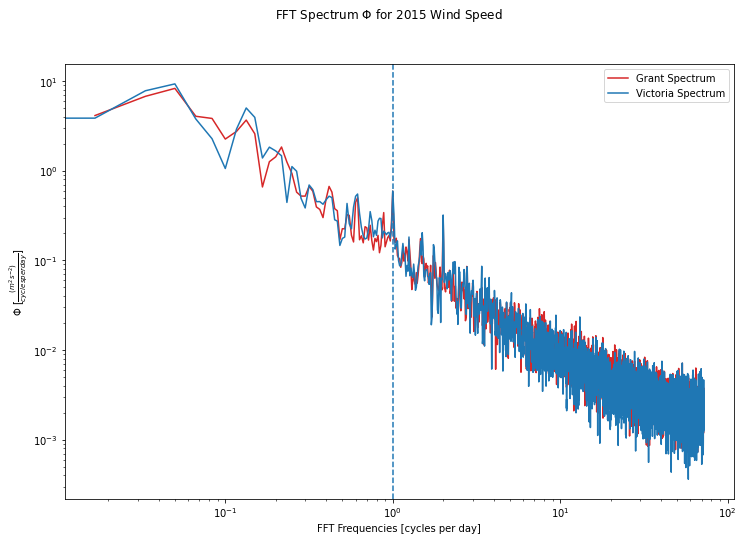

In [7]:
# plot comparing spectra 

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.suptitle(r'FFT Spectrum $\Phi$ for 2015 Wind Speed')
ax.plot(frequency,avg_spec,label='Grant Spectrum',color='tab:red',zorder=1)

ax.plot(f,amp,label='Victoria Spectrum',color='tab:blue',zorder=2)

ax.set_xscale('log'); ax.set_yscale('log')
ax.set(ylabel=r'$\Phi$ [$ \frac{(m^2 s^{-2})}{ cycles per day } $]',xlabel=r'FFT Frequencies [cycles per day]')
ax.axvline(x=1,linestyle='--')
#ax.set_ylim([10e-5, 10e1])
ax.legend(fontsize=10,loc='upper right')
plt.show()
